In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [58]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import os
import pickle
from matplotlib.cm import get_cmap
import sys
import nltk
import pyonmttok

TOKENIZER = pyonmttok.Tokenizer("aggressive", joiner_annotate=False, segment_numbers=True)

In [40]:
inter_dataset_folders = ['/Users/ff/dev/mathematics_dataset-v1.0/interpolate-split',
                        '/Users/ff/dev/mathematics_dataset-v1.0/interpolate-split-ns']

extra_dataset_folders = ['/Users/ff/dev/mathematics_dataset-v1.0/extrapolate-split',
                        '/Users/ff/dev/mathematics_dataset-v1.0/extrapolate-split-ns']

results_folders_extra = ['/Users/ff/results_20200303/results_extrapolation_100k',
                         '/Users/ff/results_ns_20200316/ns_20200316_extra_96000']

results_folders_inter = ['/Users/ff/results_20200303/results_interpolation_100k',
                         '/Users/ff/results_ns_20200316/ns_20200316_inter_96000']

checkpoints = [100000, 40000, 40000]

inter_targets = sorted(['algebra__polynomial_roots_tgt_test.txt',
                 'arithmetic__add_or_sub_tgt_test.txt',
                 'arithmetic__add_sub_multiple_tgt_test.txt',
                 'arithmetic__div_tgt_test.txt',
                 'arithmetic__mixed_tgt_test.txt',
                 'arithmetic__mul_div_multiple_tgt_test.txt',
                 'arithmetic__mul_tgt_test.txt',
                 'comparison__closest_tgt_test.txt',
                 'comparison__kth_biggest_tgt_test.txt',
                 'comparison__sort_tgt_test.txt',
                 'measurement__conversion_tgt_test.txt',
                 'numbers__place_value_tgt_test.txt',
                 'numbers__round_number_tgt_test.txt',
                 'probability__swr_p_level_set_tgt_test.txt',
                 'probability__swr_p_sequence_tgt_test.txt'])

inter_sources = sorted(['algebra__polynomial_roots_src_test.txt',
                 'arithmetic__add_or_sub_src_test.txt',
                 'arithmetic__add_sub_multiple_src_test.txt',
                 'arithmetic__div_src_test.txt',
                 'arithmetic__mixed_src_test.txt',
                 'arithmetic__mul_div_multiple_src_test.txt',
                 'arithmetic__mul_src_test.txt',
                 'comparison__closest_src_test.txt',
                 'comparison__kth_biggest_src_test.txt',
                 'comparison__sort_src_test.txt',
                 'measurement__conversion_src_test.txt',
                 'numbers__place_value_src_test.txt',
                 'numbers__round_number_src_test.txt',
                 'probability__swr_p_level_set_src_test.txt',
                 'probability__swr_p_sequence_src_test.txt'])


extra_targets = sorted(['algebra__polynomial_roots_big_tgt_test.txt',
                 'arithmetic__add_or_sub_big_tgt_test.txt',
                 'arithmetic__add_sub_multiple_longer_tgt_test.txt',
                 'arithmetic__div_big_tgt_test.txt',
                 'arithmetic__mixed_longer_tgt_test.txt',
                 'arithmetic__mul_big_tgt_test.txt',
                 'arithmetic__mul_div_multiple_longer_tgt_test.txt',
                 'comparison__closest_more_tgt_test.txt',
                 'comparison__kth_biggest_more_tgt_test.txt',
                 'comparison__sort_more_tgt_test.txt',
                 'measurement__conversion_tgt_test.txt',
                 'numbers__place_value_big_tgt_test.txt',
                 'numbers__round_number_big_tgt_test.txt',
                 'probability__swr_p_level_set_more_samples_tgt_test.txt',
                 'probability__swr_p_sequence_more_samples_tgt_test.txt'])

extra_sources = sorted(['algebra__polynomial_roots_big_src_test.txt',
                 'arithmetic__add_or_sub_big_src_test.txt',
                 'arithmetic__add_sub_multiple_longer_src_test.txt',
                 'arithmetic__div_big_src_test.txt',
                 'arithmetic__mixed_longer_src_test.txt',
                 'arithmetic__mul_big_src_test.txt',
                 'arithmetic__mul_div_multiple_longer_src_test.txt',
                 'comparison__closest_more_src_test.txt',
                 'comparison__kth_biggest_more_src_test.txt',
                 'comparison__sort_more_src_test.txt',
                 'measurement__conversion_src_test.txt',
                 'numbers__place_value_big_src_test.txt',
                 'numbers__round_number_big_src_test.txt',
                 'probability__swr_p_level_set_more_samples_src_test.txt',
                 'probability__swr_p_sequence_more_samples_src_test.txt'])

In [37]:
def pair_files_in_folders(folders):
    res = {}
    for folder in sorted(folders):
        res[folder] = []
        for file in sorted(os.listdir(folder)):
            if file.endswith(".txt"):
                res[folder].append(os.path.join(folder, file))
    return res

In [42]:
# Find and pair results files for each taks and each model
# this is a dictionary with the experiment name as key and a list of src files
extra_hyp_files = pair_files_in_folders(results_folders_extra)
inter_hyp_files = pair_files_in_folders(results_folders_inter)

In [41]:
print(extra_hyp_files)

{'/Users/ff/results_20200303/results_extrapolation_100k/': ['/Users/ff/results_20200303/results_extrapolation_100k/pred_valid_algebra__polynomial_roots_big_src_test.txt_100000.txt', '/Users/ff/results_20200303/results_extrapolation_100k/pred_valid_arithmetic__add_or_sub_big_src_test.txt_100000.txt', '/Users/ff/results_20200303/results_extrapolation_100k/pred_valid_arithmetic__add_sub_multiple_longer_src_test.txt_100000.txt', '/Users/ff/results_20200303/results_extrapolation_100k/pred_valid_arithmetic__div_big_src_test.txt_100000.txt', '/Users/ff/results_20200303/results_extrapolation_100k/pred_valid_arithmetic__mixed_longer_src_test.txt_100000.txt', '/Users/ff/results_20200303/results_extrapolation_100k/pred_valid_arithmetic__mul_big_src_test.txt_100000.txt', '/Users/ff/results_20200303/results_extrapolation_100k/pred_valid_arithmetic__mul_div_multiple_longer_src_test.txt_100000.txt', '/Users/ff/results_20200303/results_extrapolation_100k/pred_valid_comparison__closest_more_src_test.tx

In [142]:
def compute_accuracies(ref_lines, hyp_lines):
    bleus = np.zeros(len(ref_lines))
    accs = np.zeros(len(ref_lines))

    # https://www.nltk.org/_modules/nltk/translate/bleu_score.html
    smoothing_function = nltk.translate.bleu_score.SmoothingFunction().method1
    
    for i, (ref_line, hyp_line) in enumerate(zip(ref_lines[:10], hyp_lines[:10])):
        ref = ref_line.strip().split(' ')
        refs = [ref]
        hyp = hyp_line.strip().split(' ')
        accs[i] = (1 if np.array_equal(ref,hyp) else 0)
        #print(ref, hyp)

    #list_of_references = [[s.strip().split(' ')] for s in ref_lines]
    #hypotheses = [s.strip().split(' ') for s in hyp_lines]
    #corpus_bleu = nltk.translate.bleu_score.corpus_bleu(list_of_references, hypotheses)

    return (accs)#, bleus, corpus_bleu

def compute_number_of_tokens(source):
    with open(source, 'r') as f:
        source_lines = f.readlines()

    n_tokens = np.zeros(len(source_lines))

    for i, line in enumerate(source_lines):
        tokens,_ = TOKENIZER.tokenize(line)
        # Remove underscores
        #tokens = [t for t in tokens if t != '_']
        n_tokens[i] = len(tokens)
    return n_tokens

def plot_accuracies(targets, sources, dataset_folders, hyp_files, title):
    plt.figure(figsize=(10,3))
    plt.tight_layout()
    plt.title(title)
    colors = ['b', 'g', 'r', 'y', ]
    
    bars = []
    bar_width = 1 / (len(hyp_files) + 1)
    for i in range(len(hyp_files)):
        bars.append(np.arange(len(targets)) + bar_width * i)

    out = {}
    for i, (t,s) in enumerate(zip(targets, sources)):
        prev_target = ''
        
        out[(t,s)] = {}
        
        for j,key in enumerate(sorted(hyp_files.keys())):
            target = os.path.join(dataset_folders[j], t)
            
            source = os.path.join(dataset_folders[j], s)

            # Compute number of tokens in source file
            n_tokens = compute_number_of_tokens(source)

            # Avoid loading targets too many times
            if target != prev_target:
                prev_target = target
                with open(target, 'r') as f:
                    ref_lines = f.readlines()
            
            # Read files
            with open(os.path.join(hyp_files[key][i]), 'r') as f:
                hyp_lines = f.readlines()
                
            accs = compute_accuracies(ref_lines, hyp_lines)
                   
            out[(t,s)][key] = (accs, n_tokens)
            
            plt.bar(bars[j][i], accs.mean(), color=get_cmap('tab10').colors[j], width=bar_width, alpha=0.7)
    
    plt.xticks(bars[len(bars)//2], targets, rotation='vertical')

    plt.legend([os.path.basename(os.path.normpath(p)) for p in sorted(hyp_files.keys())], 
               fontsize=9,
               bbox_to_anchor=(0.0, 1.01))
    plt.show()
    
    return out

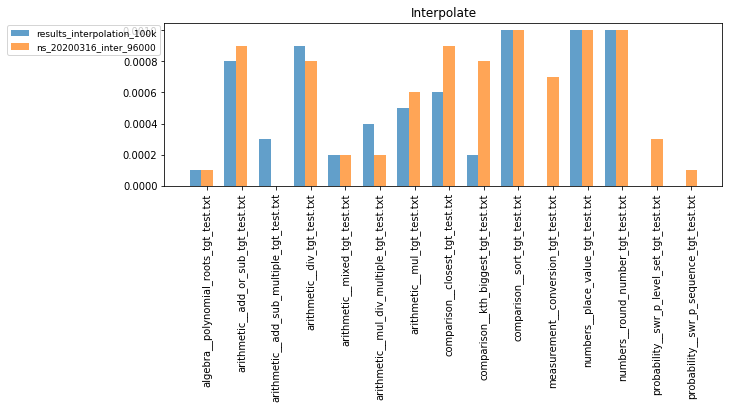

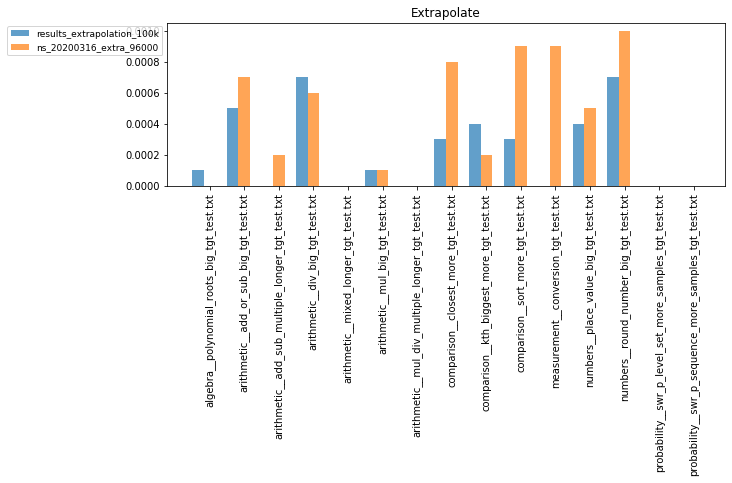

In [143]:
data_inter = plot_accuracies(inter_targets, 
                             inter_sources, 
                             inter_dataset_folders, 
                             inter_hyp_files, 
                             title='Interpolate')
data_extra = plot_accuracies(extra_targets, 
                             extra_sources, 
                             extra_dataset_folders, 
                             extra_hyp_files, 
                             title='Extrapolate')

In [144]:
def check_increased_accuracy(data, targets, sources, hyp_files):
     for i, (t,s) in enumerate(zip(targets, sources)):
        accuracies = None
        tokens = None
        for j,key in enumerate(sorted(hyp_files.keys())):
            print(key)
            accs, n_tokens = data[(t,s)][key]
            # Stack matrices together
            if np.all(accuracies == None):
                accuracies = accs
                tokens = n_tokens
            else:
                accuracies = np.stack((accuracies, accs))
                tokens = np.stack((tokens, n_tokens))


        # Compute difference between the char tokenization and the word tokenization
        # row 0 is baseline
        # row 1 is number segmentation
        diff = tokens[0,:] - tokens[1,:]
        accs = {}
        n_examples = accuracies.shape[1]

        # Prepare plotting
        plt.figure(figsize=(10,3))
        plt.tight_layout()
        #plt.title(title)
        #colors = ['b', 'g', 'r', 'y', ]

        bars = []
        bar_width = 1 / (len(hyp_files) + 1)
        for i in range(len(hyp_files)):
            bars.append(np.arange(int(diff.min()), int(diff.max()+1)) + bar_width * i)

        for n in range(int(diff.min()), int(diff.max()+1)):
            indices = np.argwhere(diff == n)
            acc_1 = accuracies[0,indices].sum() / n_examples
            acc_2 = accuracies[1,indices].sum() / n_examples

            plt.bar(bars[0][n-int(diff.min())], acc_1, color=get_cmap('tab10').colors[0], width=bar_width, alpha=0.7)
            plt.bar(bars[1][n-int(diff.min())], acc_2, color=get_cmap('tab10').colors[1], width=bar_width, alpha=0.7)

        plt.legend([os.path.basename(os.path.normpath(p)) for p in sorted(hyp_files.keys())])
        plt.xlabel('Difference in #tokens (#chars - #words)', fontsize=12)
        plt.ylabel('Binary accuracy', fontsize=12)
        plt.title(t)
        plt.show()
        #plt.hist(diff)
        #plt.show()

***********************
   INTERPOLATE   
***********************

/Users/ff/results_20200303/results_interpolation_100k
/Users/ff/results_ns_20200316/ns_20200316_inter_96000


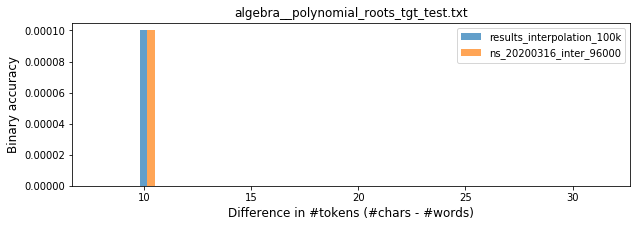

/Users/ff/results_20200303/results_interpolation_100k
/Users/ff/results_ns_20200316/ns_20200316_inter_96000


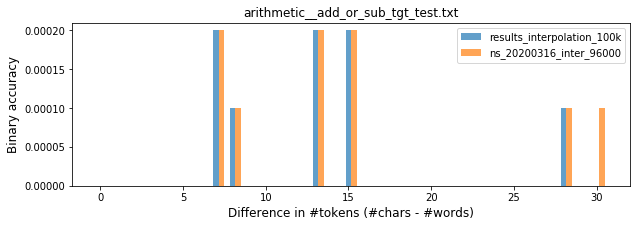

/Users/ff/results_20200303/results_interpolation_100k
/Users/ff/results_ns_20200316/ns_20200316_inter_96000


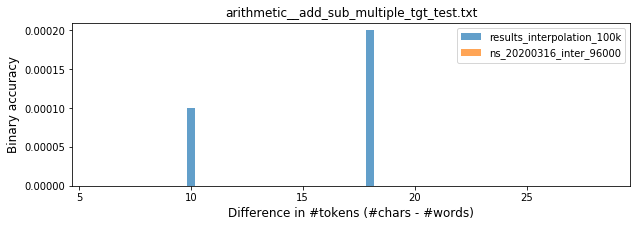

/Users/ff/results_20200303/results_interpolation_100k
/Users/ff/results_ns_20200316/ns_20200316_inter_96000


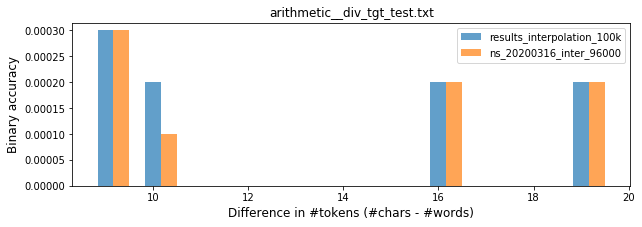

/Users/ff/results_20200303/results_interpolation_100k
/Users/ff/results_ns_20200316/ns_20200316_inter_96000


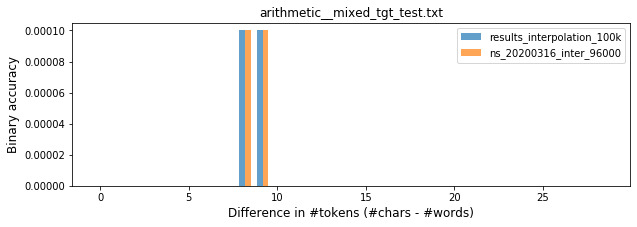

/Users/ff/results_20200303/results_interpolation_100k
/Users/ff/results_ns_20200316/ns_20200316_inter_96000


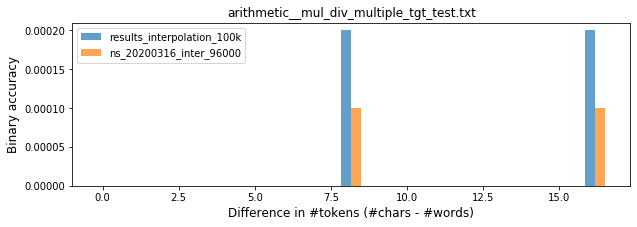

/Users/ff/results_20200303/results_interpolation_100k
/Users/ff/results_ns_20200316/ns_20200316_inter_96000


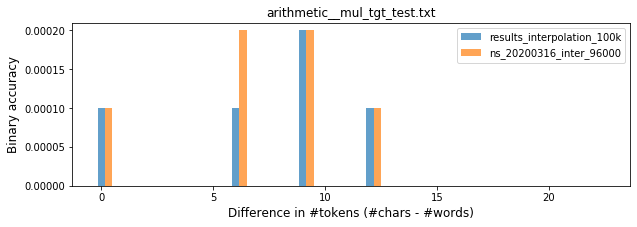

/Users/ff/results_20200303/results_interpolation_100k
/Users/ff/results_ns_20200316/ns_20200316_inter_96000


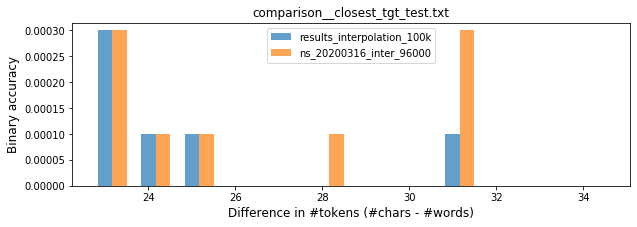

/Users/ff/results_20200303/results_interpolation_100k
/Users/ff/results_ns_20200316/ns_20200316_inter_96000


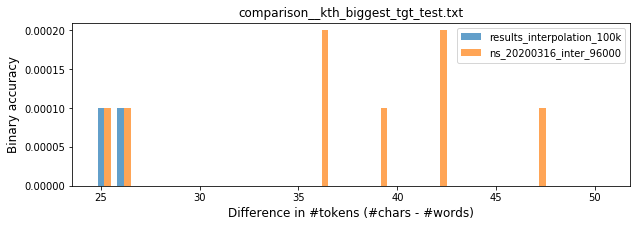

/Users/ff/results_20200303/results_interpolation_100k
/Users/ff/results_ns_20200316/ns_20200316_inter_96000


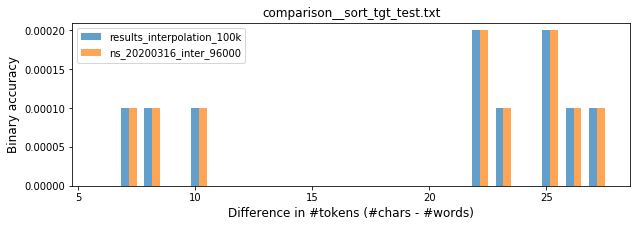

/Users/ff/results_20200303/results_interpolation_100k
/Users/ff/results_ns_20200316/ns_20200316_inter_96000


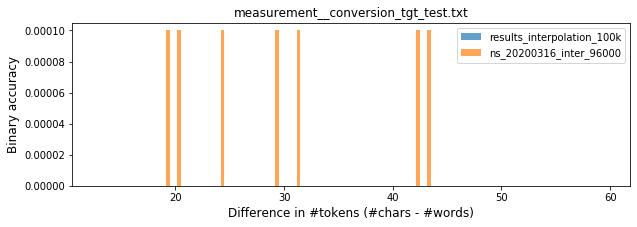

/Users/ff/results_20200303/results_interpolation_100k
/Users/ff/results_ns_20200316/ns_20200316_inter_96000


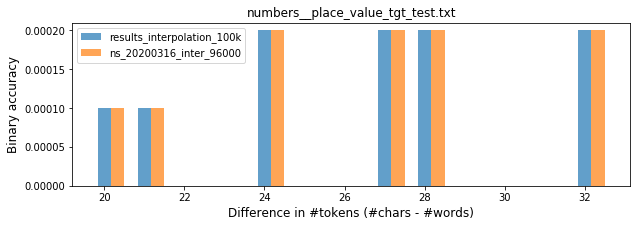

/Users/ff/results_20200303/results_interpolation_100k
/Users/ff/results_ns_20200316/ns_20200316_inter_96000


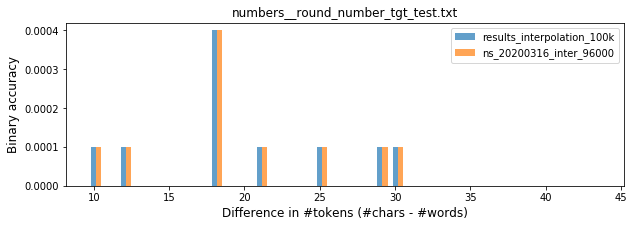

/Users/ff/results_20200303/results_interpolation_100k
/Users/ff/results_ns_20200316/ns_20200316_inter_96000


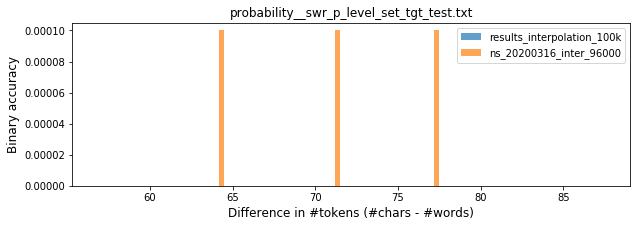

/Users/ff/results_20200303/results_interpolation_100k
/Users/ff/results_ns_20200316/ns_20200316_inter_96000


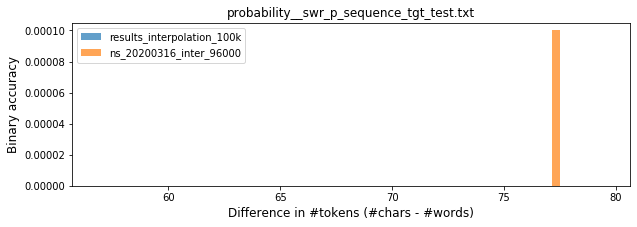






***********************
   EXTRAPOLATE   
***********************

/Users/ff/results_20200303/results_extrapolation_100k
/Users/ff/results_ns_20200316/ns_20200316_extra_96000


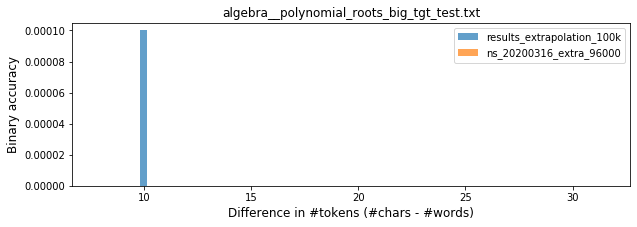

/Users/ff/results_20200303/results_extrapolation_100k
/Users/ff/results_ns_20200316/ns_20200316_extra_96000


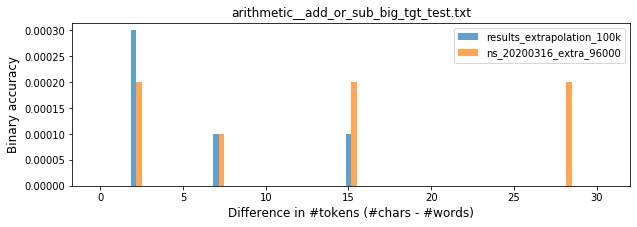

/Users/ff/results_20200303/results_extrapolation_100k
/Users/ff/results_ns_20200316/ns_20200316_extra_96000


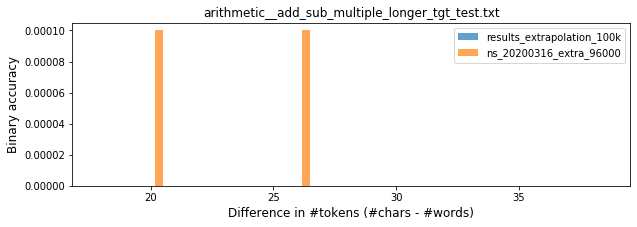

/Users/ff/results_20200303/results_extrapolation_100k
/Users/ff/results_ns_20200316/ns_20200316_extra_96000


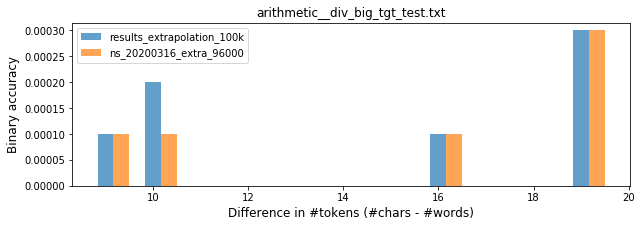

/Users/ff/results_20200303/results_extrapolation_100k
/Users/ff/results_ns_20200316/ns_20200316_extra_96000


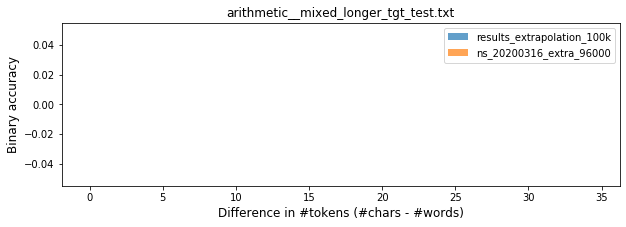

/Users/ff/results_20200303/results_extrapolation_100k
/Users/ff/results_ns_20200316/ns_20200316_extra_96000


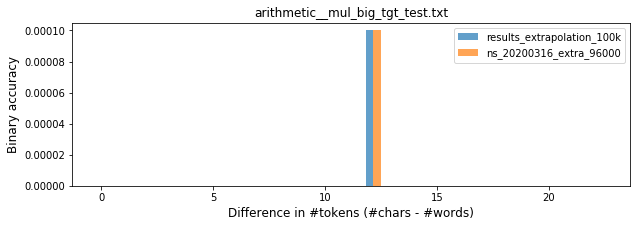

/Users/ff/results_20200303/results_extrapolation_100k
/Users/ff/results_ns_20200316/ns_20200316_extra_96000


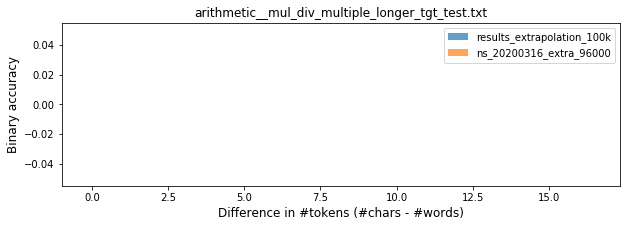

/Users/ff/results_20200303/results_extrapolation_100k
/Users/ff/results_ns_20200316/ns_20200316_extra_96000


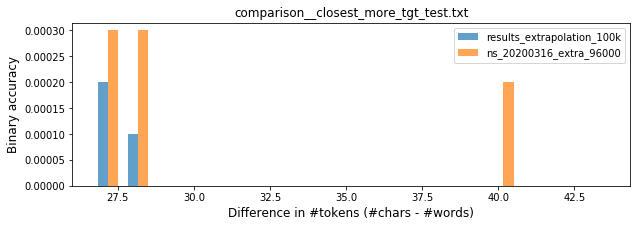

/Users/ff/results_20200303/results_extrapolation_100k
/Users/ff/results_ns_20200316/ns_20200316_extra_96000


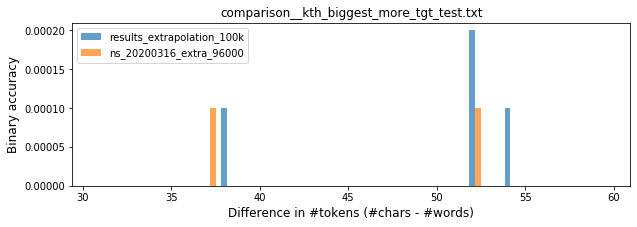

/Users/ff/results_20200303/results_extrapolation_100k
/Users/ff/results_ns_20200316/ns_20200316_extra_96000


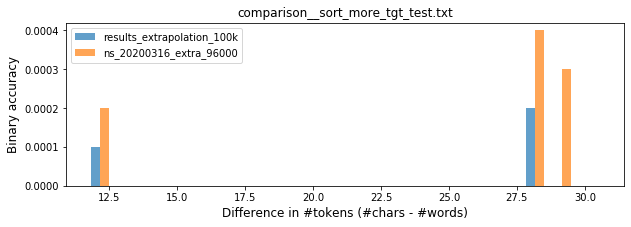

/Users/ff/results_20200303/results_extrapolation_100k
/Users/ff/results_ns_20200316/ns_20200316_extra_96000


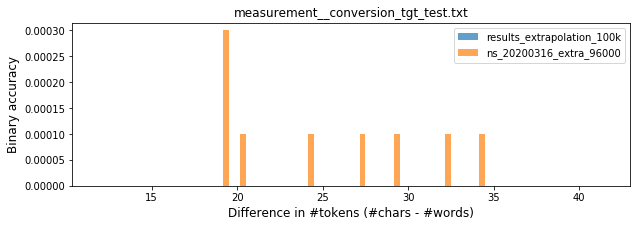

/Users/ff/results_20200303/results_extrapolation_100k
/Users/ff/results_ns_20200316/ns_20200316_extra_96000


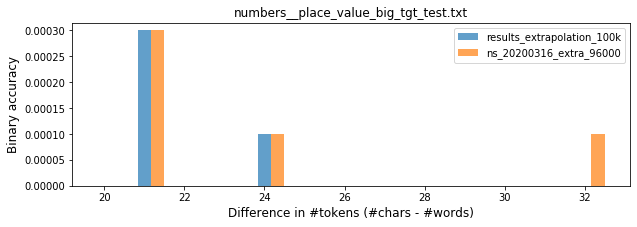

/Users/ff/results_20200303/results_extrapolation_100k
/Users/ff/results_ns_20200316/ns_20200316_extra_96000


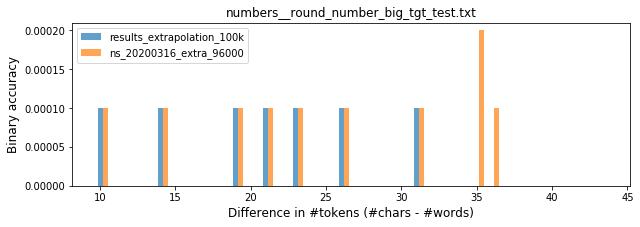

/Users/ff/results_20200303/results_extrapolation_100k
/Users/ff/results_ns_20200316/ns_20200316_extra_96000


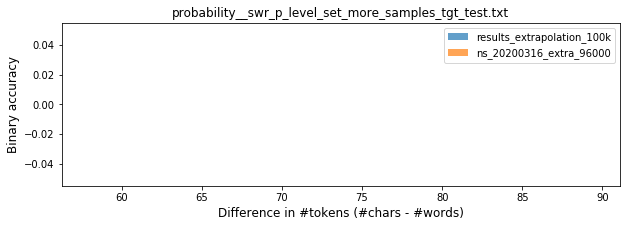

/Users/ff/results_20200303/results_extrapolation_100k
/Users/ff/results_ns_20200316/ns_20200316_extra_96000


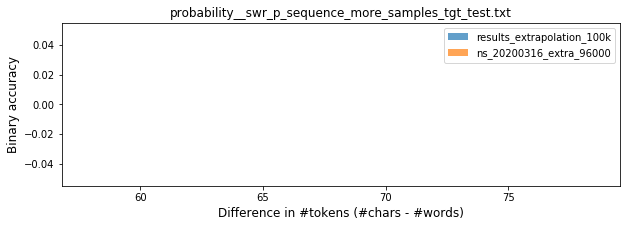

In [145]:
print('***********************')
print('   INTERPOLATE   ')
print('***********************')
print()
check_increased_accuracy(data_inter, inter_targets, inter_sources, inter_hyp_files)

print()
print()
print()
print()
print()
print('***********************')
print('   EXTRAPOLATE   ')
print('***********************')
print()
check_increased_accuracy(data_extra, extra_targets, extra_sources, extra_hyp_files)